# CNN Baseline - iWildCam 2019

Breakdown of this notebook:
1. **Loading the 32x32 dataset**: Load the data generated in *Reducing Image Sizes to 32x32*.
2. **Create Callback for F1 Score**: F1-macro score is the official metric of the competition. We create a callback to keep track of that value as we train the model.
3. **Creating and Training the Model**: Create a simple model (taken from the official Keras tutorial) and train it.
4. **Evaluation**: Display the plots from the training history.
5. **Submission**: Run predictions with `model.predict`, and create submission csv file.

### References
* [cifar10_cnn_keras.py](https://github.com/keras-team/keras/blob/master/examples/cifar10_cnn.py): Heavily inspired from this tutorial created by the Keras team. The architecture and training process is directly taken from them.
* [Keras CNN Starter - PetFinder](https://www.kaggle.com/xhlulu/keras-cnn-starter-petfinder/): History plot and submission are inspired by this kernel
* [Reducing Image Sizes to 32x32](https://www.kaggle.com/xhlulu/reducing-image-sizes-to-32x32): Image data (`X_train`, `X_test`) come from the output of this kernel.
* [How to compute f1 score for each epoch in Keras](https://medium.com/@thongonary/how-to-compute-f1-score-for-each-epoch-in-keras-a1acd17715a2): Needed to compute the F1 Score after each epoch.

In [2]:
import os
import json

import numpy as np
import pandas as pd
import keras
from keras.callbacks import Callback
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [3]:
print(keras.__version__)

2.2.4


In [4]:
os.listdir('../input')

['reducing-image-sizes-to-32x32', 'iwildcam-2019-fgvc6', 'fft-test-image']

# 0. FFT Setup

In [5]:
import cv2
import numpy as np
import tensorflow as tf
# from tensorflow import signal
import numpy.fft as fft
import matplotlib as mpl

import matplotlib.pyplot as plt

%matplotlib inline
mpl.rcParams['figure.figsize'] = (12, 5)
mpl.rcParams['image.cmap'] = "gray"

In [6]:

def image_n_fft(real_img, plot=False):
    if plot==True:
#         real_img = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
        Img = fft.fft2(real_img)
        mag = np.abs(fft.fftshift(Img))
        plt.subplot(1,2,1)
        plt.imshow(real_img); plt.axis('off');
        plt.subplot(1,2,2)
        plt.imshow(20*np.log10(mag**2 + 1)); plt.axis('off'); plt.title('Power (dB)');
    return fft.fft2(real_img)

In [7]:
def image_n_fft_ranged(real_img, range_low, range_high, plot=False):
    x, y = np.meshgrid(range(real_img.shape[0]), range(real_img.shape[1]))
    r = np.sqrt((x - x.mean())**2 + (y - y.mean())**2)
        
    if plot==True:
#         real_img = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
#         print(type(real_img))
        Img = fft.fft2(real_img)

        _Img = np.where((r > range_low) & (r < range_high), fft.fftshift(Img), 0)
        mag = np.abs(_Img)
        plt.subplot(1,2,1)
        plt.imshow(fft.ifft2(fft.fftshift(_Img)).real); plt.axis('off');
        plt.subplot(1,2,2)
        plt.imshow(20*np.log10(mag**2 + 1)); plt.axis('off'); plt.title('Power (dB)');
        print(type(fft.ifft2(fft.fftshift(_Img)).real))
        print(fft.ifft2(fft.fftshift(_Img)).real)
    
    return np.where((r > range_low) & (r < range_high), fft.fftshift(fft.fft2(real_img)), 0)

array([[ 6.32583950e+07      +0.j        ,
        -3.82785724e+06-1243563.69750258j,
        -2.19446775e+06+2484085.27256107j, ...,
        -1.87848537e+05 +997766.70685262j,
        -2.19446775e+06-2484085.27256107j,
        -3.82785724e+06+1243563.69750258j],
       [-7.08443323e+06-2880064.69855541j,
         8.68545260e+05 +277713.1103071j ,
         2.55913946e+06-2426482.9691034j , ...,
         7.02057946e+04  +22034.06267725j,
         2.38602999e+06 +404183.72010101j,
        -5.11195315e+06 -744233.31960675j],
       [ 8.09115887e+05-1912039.26633563j,
        -5.26427476e+05 -772299.3815135j ,
        -7.08210545e+04 +815050.56381426j, ...,
         7.10894092e+05-1254758.55562614j,
        -3.57206446e+04 +317388.74406846j,
        -4.08389229e+05 +934441.38538909j],
       ...,
       [ 2.02554094e+05 -932594.047056j  ,
         5.51799327e+05+1328428.54044855j,
        -3.61180400e+05 -173652.52259134j, ...,
         8.32755943e+05 -558058.91547562j,
        -6.36016353

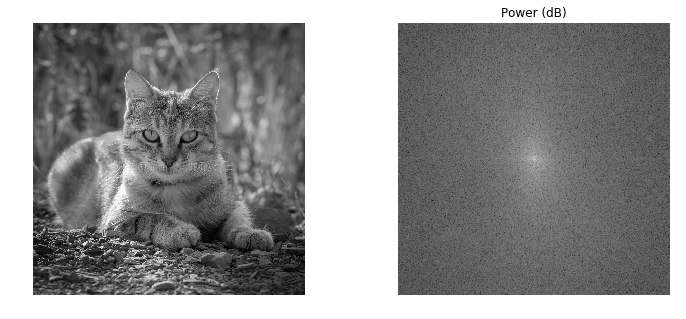

In [8]:
real_img = cv2.imread('../input/fft-test-image/test.jpg', cv2.IMREAD_GRAYSCALE)
image_n_fft(real_img, True)

<class 'numpy.ndarray'>
[[ 5.63039893  6.53533917  7.2250857  ...  1.82478031  3.24970565
   4.52749391]
 [ 6.94314903  7.53091353  7.88906181 ...  3.96403279  5.1374887
   6.1388261 ]
 [ 8.16628465  8.43040461  8.45091161 ...  6.03679565  6.9503338
   7.66755191]
 ...
 [ 1.5152986   3.29031292  4.89513131 ... -4.51340522 -2.42179585
  -0.40004172]
 [ 2.88013764  4.38272586  5.69991125 ... -2.4613109  -0.57385268
   1.21783863]
 [ 4.26384131  5.47511069  6.48595113 ... -0.33304231  1.33108375
   2.87360219]]


array([[0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
       ...,
       [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j]])

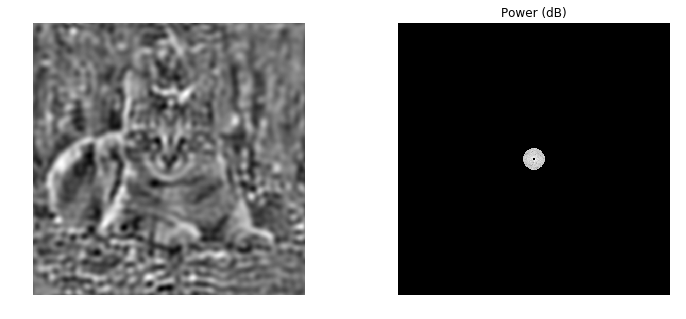

In [9]:
image_n_fft_ranged(real_img, 4 ,32, True)


## 1. Loading the 32x32 dataset

In [10]:
# The data, split between train and test sets:
x_train = np.load('../input/reducing-image-sizes-to-32x32/X_train.npy')
x_test = np.load('../input/reducing-image-sizes-to-32x32/X_test.npy')
y_train = np.load('../input/reducing-image-sizes-to-32x32/y_train.npy')

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (196299, 32, 32, 3)
196299 train samples
153730 test samples


In [11]:
# Convert the images to float and scale it to a range of 0 to 1
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255.
x_test /= 255.

In [12]:
i=0
for pic in x_train:
    if i==0:
        print(pic.shape)

    pic = image_n_fft(pic)
    i+=1

for pic in x_test:
    pic = image_n_fft(pic)
    
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

(32, 32, 3)
x_train shape: (196299, 32, 32, 3)
196299 train samples
153730 test samples


## 2. Create Callback for F1 score

In [40]:
class Metrics(Callback):
    def on_train_begin(self, logs={}):
        self.val_f1s = []
        self.val_recalls = []
        self.val_precisions = []

    def on_epoch_end(self, epoch, logs={}):
        X_val, y_val = self.validation_data[:2]
        y_pred = self.model.predict(X_val)

        y_pred_cat = keras.utils.to_categorical(
            y_pred.argmax(axis=1),
            num_classes=num_classes
        )

        _val_f1 = f1_score(y_val, y_pred_cat, average='macro')
        _val_recall = recall_score(y_val, y_pred_cat, average='macro')
        _val_precision = precision_score(y_val, y_pred_cat, average='macro')

        self.val_f1s.append(_val_f1)
        self.val_recalls.append(_val_recall)
        self.val_precisions.append(_val_precision)

        print((f"val_f1: {_val_f1:.4f}"
               f" — val_precision: {_val_precision:.4f}"
               f" — val_recall: {_val_recall:.4f}"))

        return

## 3. Creating and Training the Model

In [41]:
batch_size = 64
num_classes = 14
epochs = 30
val_split = 0.1
save_dir = os.path.join(os.getcwd(), 'models')
print(save_dir)
model_name = 'keras_cnn_model.h5'

/kaggle/working/models


In [42]:
print(x_train.shape[1:])

(32, 32, 3)


In [43]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
print(x_train.shape[1:])
model.add(Activation('relu'))
print(model)
print(model.summary())
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
print(model.summary())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

Instructions for updating:
Colocations handled automatically by placer.
(32, 32, 3)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
Total params: 896
Trainable params: 896
Non-trainable params: 0
_________________________________________________________________
None
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 32)        

In [44]:
f1_metrics = Metrics()

model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

hist = model.fit(
    x_train, 
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=[f1_metrics],
    validation_split=val_split,
    shuffle=True
)

Instructions for updating:
Use tf.cast instead.
Train on 176669 samples, validate on 19630 samples
Epoch 1/30
176669/176669 [==============================] - 23s 132us/step - loss: 0.7084 - acc: 0.7798 - val_loss: 0.4838 - val_acc: 0.8438
val_f1: 0.5071 — val_precision: 0.6056 — val_recall: 0.4848
Epoch 2/30
  1600/176669 [..............................] - ETA: 18s - loss: 0.5151 - acc: 0.8263

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


176669/176669 [==============================] - 19s 107us/step - loss: 0.5121 - acc: 0.8342 - val_loss: 0.4037 - val_acc: 0.8647
val_f1: 0.6252 — val_precision: 0.7338 — val_recall: 0.5904
Epoch 3/30
176669/176669 [==============================] - 19s 106us/step - loss: 0.4524 - acc: 0.8520 - val_loss: 0.3754 - val_acc: 0.8791
val_f1: 0.7001 — val_precision: 0.7547 — val_recall: 0.6825
Epoch 4/30
176669/176669 [==============================] - 19s 108us/step - loss: 0.4152 - acc: 0.8624 - val_loss: 0.3451 - val_acc: 0.8855
val_f1: 0.7268 — val_precision: 0.7656 — val_recall: 0.7097
Epoch 5/30
176669/176669 [==============================] - 19s 108us/step - loss: 0.3913 - acc: 0.8697 - val_loss: 0.3220 - val_acc: 0.8935
val_f1: 0.7476 — val_precision: 0.7847 — val_recall: 0.7329
Epoch 6/30
176669/176669 [==============================] - 19s 105us/step - loss: 0.3700 - acc: 0.8765 - val_loss: 0.3150 - val_acc: 0.8959
val_f1: 0.7509 — val_precision: 0.7817 — val_recall: 0.7374
Epoch 

Save model and weights

In [45]:
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at /kaggle/working/models/keras_cnn_model.h5 


## 4. Evaluation

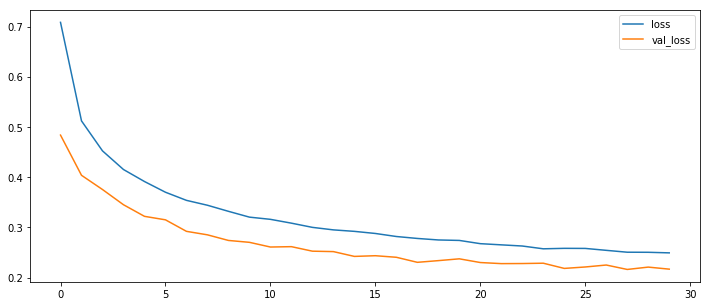

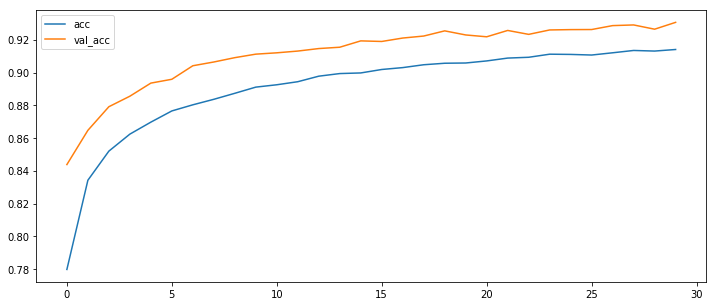

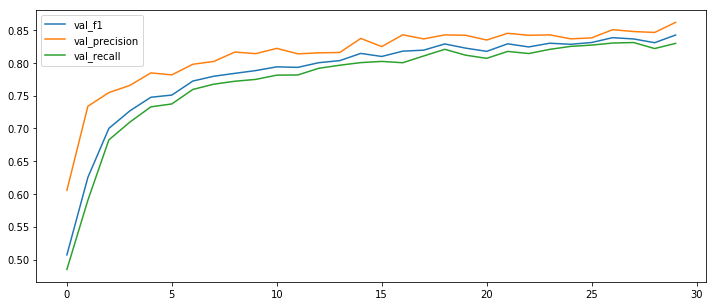

In [46]:
history_df = pd.DataFrame(hist.history)
history_df['val_f1'] = f1_metrics.val_f1s
history_df['val_precision'] = f1_metrics.val_precisions
history_df['val_recall'] = f1_metrics.val_recalls

history_df[['loss', 'val_loss']].plot()
history_df[['acc', 'val_acc']].plot()
history_df[['val_f1', 'val_precision', 'val_recall']].plot()

## 5. Submission

In [47]:
y_test = model.predict(x_test)

submission_df = pd.read_csv('../input/iwildcam-2019-fgvc6/sample_submission.csv')
submission_df['Predicted'] = y_test.argmax(axis=1)
print(submission_df.shape)
submission_df.head()

(153730, 4)


,Unnamed: 0,Id,Category,Predicted
0,0,b005e5b2-2c0b-11e9-bcad-06f10d5896c4,0,0
1,1,f2347cfe-2c11-11e9-bcad-06f10d5896c4,0,6
2,2,27cf8d26-2c0e-11e9-bcad-06f10d5896c4,0,0
3,3,f82f52c7-2c1d-11e9-bcad-06f10d5896c4,0,0
4,4,e133f50d-2c1c-11e9-bcad-06f10d5896c4,0,0


In [48]:
submission_df.to_csv('submission.csv',index=False)
history_df.to_csv('history.csv', index=False)

with open('history.json', 'w') as f:
    json.dump(hist.history, f)